In [1]:
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
from skimage.measure import block_reduce
import gc
import sys
sys.path.insert(0,'..')
from functions import *
import argparse
from matplotlib.patches import FancyArrowPatch
from scipy.optimize import curve_fit

In [2]:
def _add_twinx(fig, ax, offset=0.22):
    ax2 = ax.twiny()
    fig.subplots_adjust(bottom=offset)
    ax2.xaxis.set_ticks_position('bottom')
    ax2.xaxis.set_label_position('bottom')
    ax2.spines['bottom'].set_position(('axes',-offset))
    ax2.set_xlim((2*np.pi/ax.get_xlim()[0],2*np.pi/ax.get_xlim()[1]))
    ax2.set_xscale('log')
    ax2.set_xlabel('Wavelength [m]')

def plot_spectrum(k1d, spec, lab, plttime, time):
    fig = plt.figure(); ax = plt.gca()
    for i in range(len(plttime)):
        col = plt.cm.cubehelix(i/len(plttime))
        ax.loglog(k1d,spec[i,izpl,:],c=col,label='t=%.2f'%time[plttime[i]])
    # ax.set_ylim((1e-4,1e2))
    ax.set_ylabel(lab)
    ax.set_xlabel(r"Wavenumber [1/m]")
    ax.legend(loc='best',bbox_to_anchor=(1,1),ncol=len(plttime)//13+1)
    
    _add_twinx(fig, ax)

# Loading loop
def load_spectra(lps):
    ld = []
    sps = []
    for i in range(len(lps)):
        spec_out = {}
        ld.append(spec_out)
        lp = lps[i]
        sps.append(lp+'/figs')

        ld[i]['time'] = np.load(lp+'/time_spec.npy')
        ld[i]['plttime'] = np.load(lp+'/plttime_spec.npy')
        ld[i]['zf'] = np.load(lp+'/zf_spec.npy')
        ld[i]['k1d'] = np.load(lp+'/k1d.npy')

        ld[i]['spec_qt'] = np.load(lp+'/spec_qt.npy')
        ld[i]['spec_thl'] = np.load(lp+'/spec_thl.npy')
        ld[i]['spec_thlv'] = np.load(lp+'/spec_thlv.npy')
        ld[i]['spec_w'] = np.load(lp+'/spec_w.npy')
        ld[i]['spec_ql'] = np.load(lp+'/spec_ql.npy')

        ld[i]['spec_wqt'] = np.load(lp+'/spec_wqt.npy')
        ld[i]['spec_wthl'] = np.load(lp+'/spec_wthl.npy')
        ld[i]['spec_wthlv'] = np.load(lp+'/spec_wthlv.npy')
        ld[i]['spec_wql'] = np.load(lp+'/spec_wql.npy')
    return ld, sps

# Plot multiple runs  at same time
def plot_multiple(ld, tplt, tav, zplt, pltvars, varlab, subplt, klp=4, arrow=True, kar=255):

    fig,axs = plt.subplots(nrows=len(pltvars),ncols=len(zplt),figsize=(len(zplt)*5,len(pltvars)*4+0.4),
                           sharex=True,squeeze=False)

    lns = []; lbs = []
    are = np.zeros((len(pltvars),len(zplt)))
    for i in range(len(lps)):

        itpltmin = np.argmin(np.abs(ld[i]['time'][ld[i]['plttime']] - tplt))
        itpltmax = np.argmin(np.abs(ld[i]['time'][ld[i]['plttime']] - (tplt + tav)))
        itplt = ld[i]['plttime'][itpltmin:itpltmax]

        for j in range(len(zplt)):
            iz = np.argmin(np.abs(ld[i]['zf'] - zplt[j]))

            k1d_plt = ld[i]['k1d']

            for k in range(len(pltvars)):

                spec_plt = np.mean(ld[i][pltvars[k]][itpltmin:itpltmax,iz], axis=0)

                ln = axs[k,j].loglog(k1d_plt[::2],spec_plt[::2],c='k',linestyle=lines[i])#, dashes=dashes[i])

                if i == 0:
                    if j == 0:
                        axs[k,j].set_ylabel(varlab[k])
                    axs[k,j].axvline(k1d_plt[klp],c='Gray')

                    b0 = np.max(spec_plt)*1e-3
                    # axs[k,j].loglog(k1d_plt[100:], b0 * k1d_plt[100:] ** (-5/3), c="Gray")
                    if k == len(pltvars)-1:
                        axs[k,j].set_xlabel(r"Wavenumber [1/m]")
                        _add_twinx(fig, axs[k,j], offset=0.4)
                        axs[k,j].annotate(r'$k_m$', (0.25,-0.15),xycoords='axes fraction')        
                    if k == 0:
                        axs[k,j].set_title('z = %.0f m'%(zplt[j]))
                if k == 0 and j == 0:
                    lns.append(ln[0])
                    lbs.append(labs[i])
                if i > 0 and arrow:
                    # axs[k].axvline(k1d_plt[kar],spec_plt[kar],are[k],c='Gray')
                    # print(are[k])
                    # print((k1d_plt[kar],spec_plt[kar]), (k1d_plt[kar],are[j]))
                    ar = FancyArrowPatch(posA=(k1d_plt[kar],spec_plt[kar]), 
                                          posB=(k1d_plt[kar],are[k,j]),
                                          arrowstyle='<|-|>', color='0.5',
                                          mutation_scale=10,linestyle=lines[i])
                    axs[k,j].add_artist(ar)
                are[k,j] = spec_plt[kar]
                axs[k,j].annotate(subplt[len(pltvars)*j+k], (0.05,0.85), xycoords='axes fraction', fontsize=12)
    fig.legend(lns, lbs, bbox_to_anchor=(0.9,0.3),ncol=2)

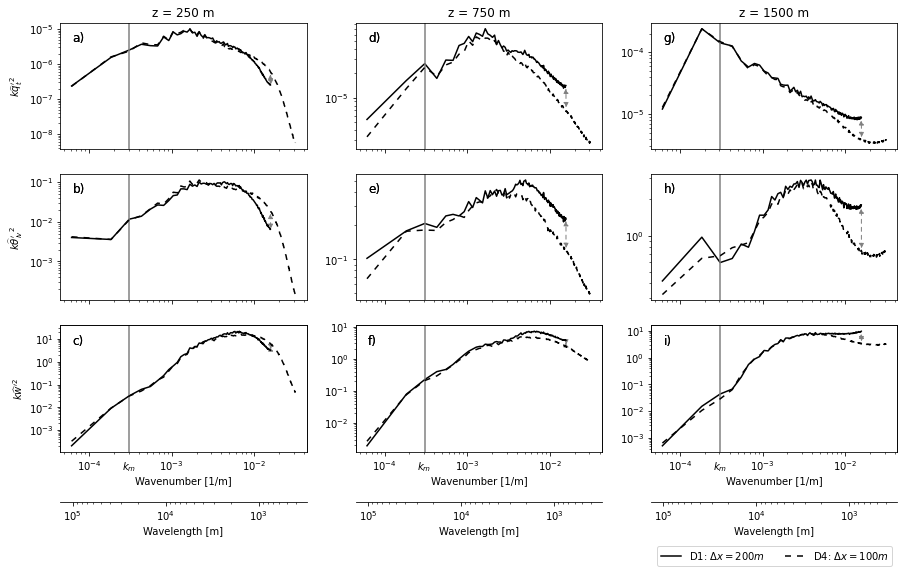

In [3]:
# Manuscript figure

## RUN SETTINGS
lps = ['../../bomex200_from100_12hr/spectra',
       '../../bomex100_e12/spectra',
      ]
labs = [r'D1: $\Delta x = 200m$',
        r'D4: $\Delta x = 100m$',
       ]

lines = ['-',
         (0, (4,4)),
        ]
sp = '../../bomex_comparisons'

## PLOT SETTINGS
tplt = 12.
tav = 1. # Hours after tplt
zplt = [250.,750.,1500.]
klp = 4
kar = 255

pltvars = ['spec_qt',
           'spec_thlv',
           'spec_w']
varlab = [r"$k\widehat{q}_t'^2$",
          r"$k\widehat{\theta}_{lv}'^2$",
          r"$k\widehat{w}'^2$"]
subplt = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)','g)', 'h)', 'i)']

ld,sps = load_spectra(lps)
plot_multiple(ld, tplt, tav, zplt, pltvars, varlab, subplt, klp=4, arrow=True, kar=255)

plt.savefig(sp+'/spectra_comparison.pdf', bbox_inches='tight')

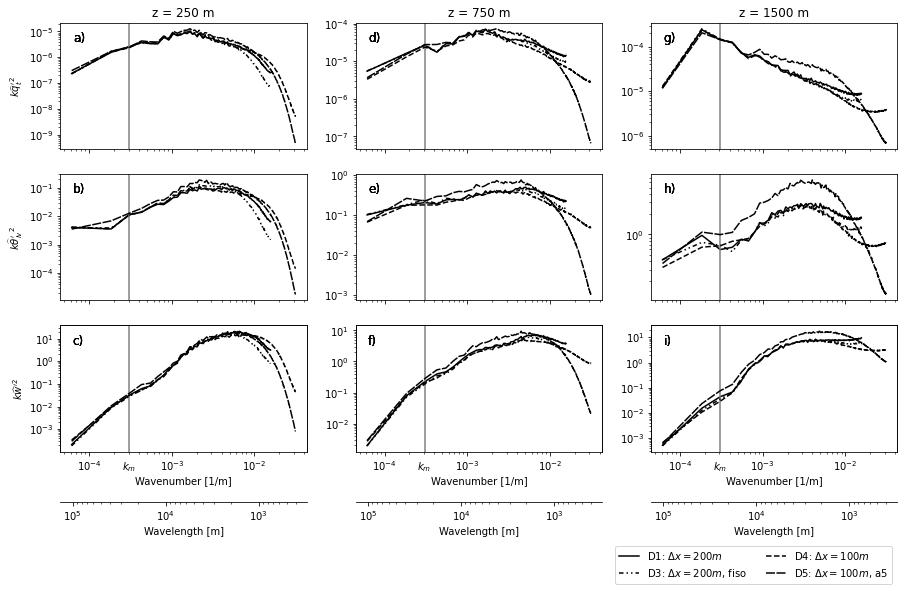

In [4]:
# All DALES runs

## RUN SETTINGS
lps = [ '../../bomex200_from100_12hr/spectra',
        '../../bomex200_fiso_from100_12hr/spectra',
        '../../bomex100_e12/spectra',
        '../../bomex100a5_from100_12hr/spectra',
       ]
labs = [r'D1: $\Delta x = 200m$',
        r'D3: $\Delta x = 200m$, fiso',
        r'D4: $\Delta x = 100m$',
        r'D5: $\Delta x = 100m$, a5',
       ]

lines = ['-',
         (0, (3, 2, 1, 2, 1, 2)),
         '--',
         (0,(6,1))
        ]

## PLOT SETTINGS
tplt = 12.
tav = 1. # Hours after tplt
zplt = [250.,750.,1500.]
klp = 4
kar = 255

pltvars = ['spec_qt',
           'spec_thlv',
           'spec_w']
varlab = [r"$k\widehat{q}_t'^2$",
          r"$k\widehat{\theta}_{lv}'^2$",
          r"$k\widehat{w}'^2$"]
subplt = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)','g)', 'h)', 'i)']

ld,sps = load_spectra(lps)
plot_multiple(ld, tplt, tav, zplt, pltvars, varlab, subplt, klp=4, arrow=False, kar=255)

plt.savefig(sp+'/spectra_comparison_dalesall.pdf', bbox_inches='tight')

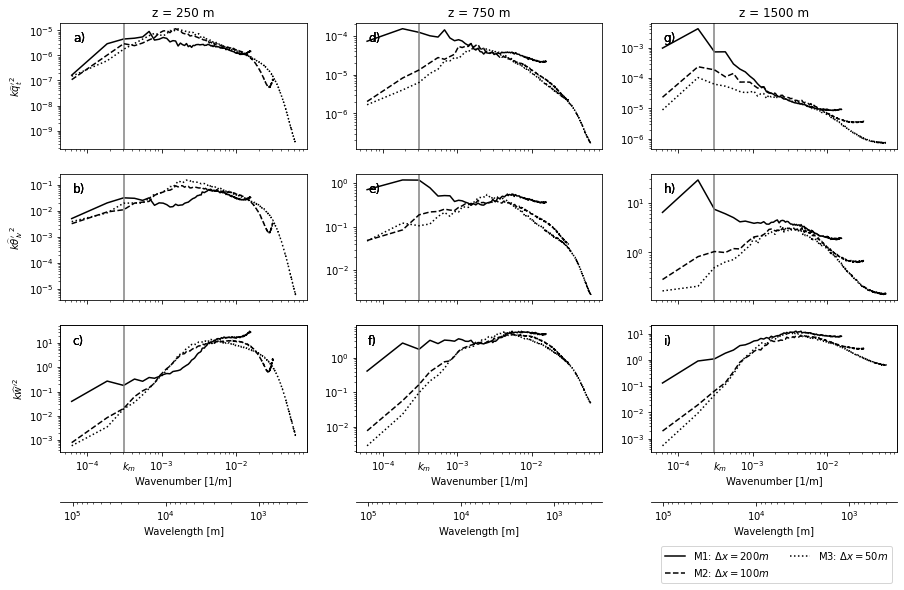

In [5]:
# All MicroHH runs

## RUN SETTINGS
lps = [ '../../bomex_mhh/bomex_200m/spectra',
        '../../bomex_mhh/bomex_100m/spectra',
        '../../bomex_mhh/bomex_50m/spectra',
       ]
labs = [r'M1: $\Delta x = 200m$',
        r'M2: $\Delta x = 100m$',
        r'M3: $\Delta x = 50m$',
       ]

lines = ['-',
         '--',
         ':']

## PLOT SETTINGS
tplt = 12.
tav = 1. # Hours after tplt
zplt = [250.,750.,1500.]
klp = 4
kar = 255

pltvars = ['spec_qt',
           'spec_thlv',
           'spec_w']
varlab = [r"$k\widehat{q}_t'^2$",
          r"$k\widehat{\theta}_{lv}'^2$",
          r"$k\widehat{w}'^2$"]
subplt = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)','g)', 'h)', 'i)']

ld,sps = load_spectra(lps)
plot_multiple(ld, tplt, tav, zplt, pltvars, varlab, subplt, klp=4, arrow=False, kar=255)

plt.savefig(sp+'/spectra_comparison_mhh.pdf', bbox_inches='tight')